# Calorie Intake Prediction
#
## 1. Imports and Data Loading

In [194]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from numpy import convolve

sns.color_palette("tab10",8)
daily_activity_merged = pd.read_csv("data/dailyActivity_merged.csv")
print(daily_activity_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   ActivityDate              940 non-null    object 
 2   TotalSteps                940 non-null    int64  
 3   TotalDistance             940 non-null    float64
 4   TrackerDistance           940 non-null    float64
 5   LoggedActivitiesDistance  940 non-null    float64
 6   VeryActiveDistance        940 non-null    float64
 7   ModeratelyActiveDistance  940 non-null    float64
 8   LightActiveDistance       940 non-null    float64
 9   SedentaryActiveDistance   940 non-null    float64
 10  VeryActiveMinutes         940 non-null    int64  
 11  FairlyActiveMinutes       940 non-null    int64  
 12  LightlyActiveMinutes      940 non-null    int64  
 13  SedentaryMinutes          940 non-null    int64  
 14  Calories  

## 2. Data cleaning and Variable Selection

<Axes: title={'center': 'Correlation matrix of filtered prediction variables'}>

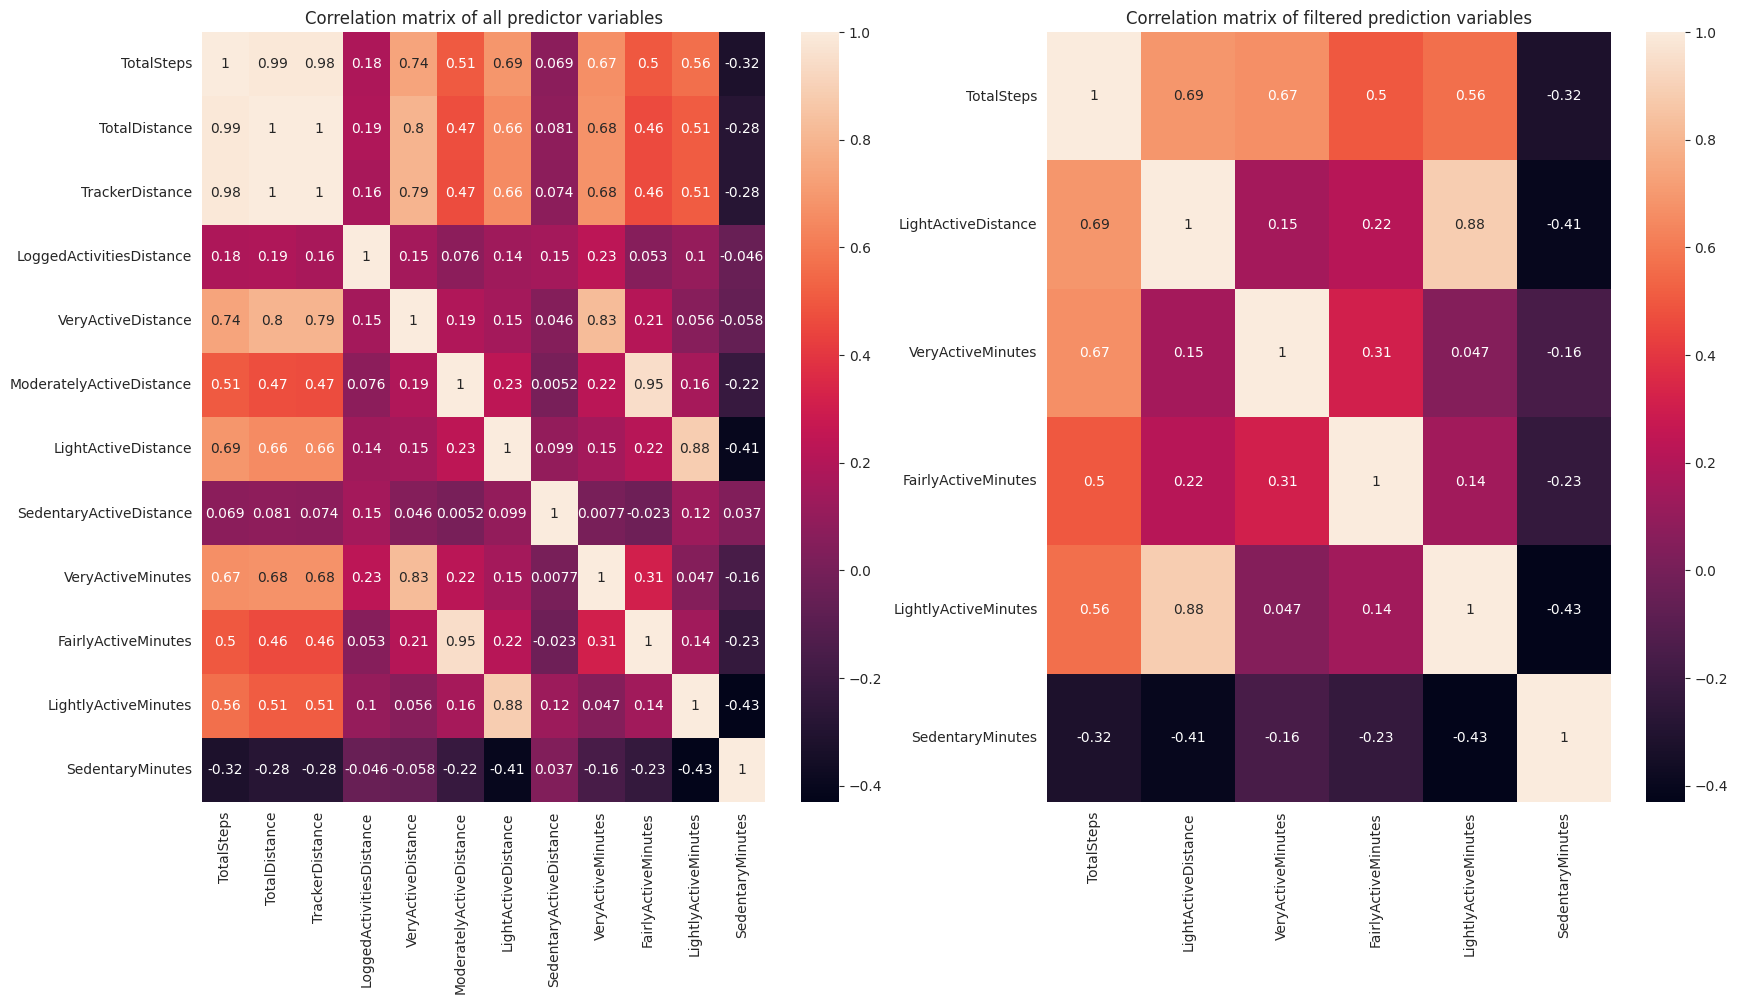

In [195]:
daily_activity_merged = daily_activity_merged.loc[daily_activity_merged["Calories"] > 0,:] # Avoid all zero values. Scaling issues you know
daily_activity_merged.drop(["Id","ActivityDate"],axis=1,inplace=True) # Not necessary for this analysis. Drop em

response_variable = daily_activity_merged.loc[:,["Calories"]] # This will be our target variable. Since we are making predictions about calories
predictor_variables = daily_activity_merged.loc[:,["TotalSteps","LightActiveDistance","VeryActiveMinutes","FairlyActiveMinutes","LightlyActiveMinutes","SedentaryMinutes"]] # Selecting uncorrelated variables


fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
axs[0].set_title("Correlation matrix of all predictor variables")
axs[1].set_title("Correlation matrix of filtered prediction variables")
sns.heatmap(daily_activity_merged.iloc[:,:-1].corr(), ax = axs[0],annot=True)
sns.heatmap(predictor_variables.corr(),ax=axs[1],annot=True)


##
## 3. Training, Cross Validation, Hyperparameter tuning

In [197]:

kf = KFold(shuffle=True,random_state=42,n_splits=3) # 3 cross validation splits

# Estimator pipeline definition
estimator = Pipeline([("scaler",StandardScaler()),("polynomial_features",PolynomialFeatures()),("ridge_regression",Ridge())])
params = {
    'polynomial_features__degree': [1, 2],
    'ridge_regression__alpha': np.geomspace(0.01, 10),  # Regularization strength
    'ridge_regression__max_iter': [5000, 10000]  # Maximum iterations
}
grid = GridSearchCV(estimator,params,cv=kf)
grid.fit(predictor_variables,response_variable)
print(f"Cross-validation Score {grid.best_score_}")

Cross-validation Score 0.6618683790235941


## 4. Performance Visualization

R^2Score == 0.7064079830720289


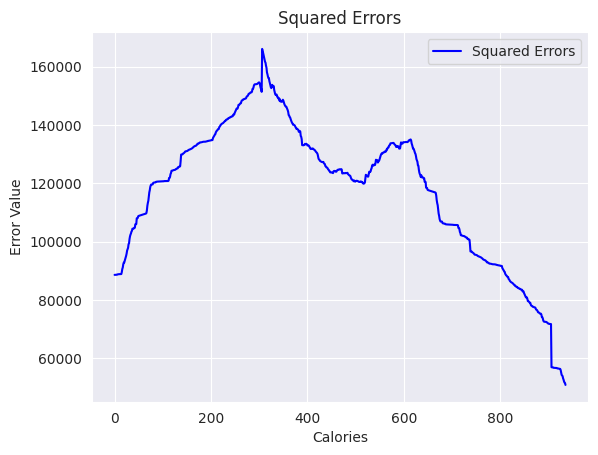

In [198]:
best_estimator = grid.best_estimator_
y_predict = best_estimator.predict(predictor_variables)

score = r2_score(response_variable,y_predict)
print(f"R^2Score == {score}")

squared_errors = (response_variable - best_estimator.predict(predictor_variables)).values.flatten() ** 2

# Apply smoothing using a moving average filter
smoothed_squared_errors = convolve(squared_errors, np.ones((600,))/600, mode='same')

sns.lineplot(x=range(len(smoothed_squared_errors)), y=smoothed_squared_errors, label='Squared Errors', color='blue')

plt.xlabel('Calories')
plt.ylabel('Error Value')
plt.title('Squared Errors')
plt.show()

# Todo
# - Define constant variables
# - 

## 5.Conclusion

There is a significant non-linear relationship between predictors and the response variable.
This can also be seen by the inconsistencies between the Cross validation score and R2_score
This is shown by the low r_score. This is also shown by the graph above. 
RScore = 0.7
